In [3]:
"This notebook is for using Leiden algorithm to divide the GRN into different communities and calculating the inter-community regulations during CPT."

'This notebook is for using Leiden algorithm to divide the GRN into different communities and calculating the inter-community regulations during CPT.'

In [2]:
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import leidenalg
from scipy import sparse
from IPython.display import SVG
import scanpy as sc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm as normal
import networkx as nx
from scipy import stats,signal
from tslearn.preprocessing import TimeSeriesResampler
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS,TSNE,SpectralEmbedding,Isomap,smacof
import seaborn as sns
from scipy.sparse.csgraph import csgraph_from_dense
from networkx.algorithms import centrality
from networkx.algorithms import cluster
from IPython.core.display import display, SVG
import leidenalg
import igraph
import louvain
from collections import defaultdict
from networkx_community_layout import community_layout
import random
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.pyplot import figure, text


In [4]:
"load data"

'load data'

In [ ]:
result_path='result/'
adata=scv.read(result_path+'EG_dyn.h5ad')
rc_extend=np.load(result_path+'EG_rc_extend.npy')

path=np.load(result_path+'EG_dyn_rc.npy')
gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)
F=np.load(result_path+'grisli_EG_F.npy')

F_sparse=np.load(result_path+'sparse_EG_F.npy')

gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)
gene_center=np.load(result_path+'EG_bin_genes_center.npy')
dim_n=10

In [5]:
"binarization"

'binarization'

In [6]:
V0_ori=adata.layers['velocity_S'].A
X0_ori=adata.layers['M_s'].A

In [7]:
bin_centers=np.load(result_path+'EG_bin_genes_center.npy',allow_pickle=True)
# print(bin_centers)
X0_bin=X0_ori.copy()
for i in range(X0_ori.shape[1]):
    gene_kc=bin_centers[i,:]
    x=X0_ori[:,i]
    x_dist0=abs(x-gene_kc[0])
    x_dist1=abs(x-gene_kc[1])
#     print(x_dist0)
    
#     print(x_dist0<x_dist1)
    
    X0_bin[:,i][x_dist0<x_dist1]=0
    X0_bin[:,i][x_dist0>=x_dist1]=1

In [8]:
X0_bin[np.where(X0_bin==0)]=-1
X0_bin.shape

(1731, 470)

In [9]:
X0=StandardScaler().fit_transform(adata.layers['M_s'].A)
V0=StandardScaler().fit_transform(adata.layers['velocity_S'].A)
gene_list=adata.var.index.values

(1731, 470)

In [6]:
"assigning the reaction coordiante of each single cell"

'assigning the reaction coordiante of each single cell'

In [10]:
data_rc=np.array([np.argmin(np.linalg.norm((adata.obsm['X_pca'][i,:dim_n]-rc_extend),axis=1)) for i in range(adata.shape[0])])
np.unique(data_rc,return_counts=True)

path_neigh=[[] for i in range(rc_extend.shape[0])]
for i in range(rc_extend.shape[0]):
#     mask=np.in1d(np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200],np.where(data_rc==i)[0])
#     path_neigh[i]=np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200][mask][:100].tolist()
#     print(len(path_neigh[i]))
    mask=np.in1d(np.where(data_rc==i)[0],np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-rc_extend[i,:]),axis=1))[:200])
    path_neigh[i]=np.where(data_rc==i)[0][mask].tolist()
    # print(len(path_neigh[i]))

7
119
50
52
56
66
104
137
89
84
82
92
116
80
96
164
71


In [ ]:
"perform community detection with 

In [11]:
F=csr_matrix((F_sparse[:,2], (F_sparse[:,0], F_sparse[:,1])), shape=(V0.shape[1],V0.shape[1])).toarray()
# G= igraph.Graph.Weighted_Adjacency(F.tolist())
res_v=1.0
partition=leidenalg.find_partition(G, leidenalg.RBConfigurationVertexPartition,resolution_parameter=res_v)
# partition=louvain.find_partition(G, louvain.ModularityVertexPartition)

In [12]:
print(partition)

Clustering with 470 elements and 3 clusters
[0] 3, 4, 5, 6, 7, 11, 12, 14, 16, 22, 25, 30, 31, 35, 36, 38, 39, 40, 45, 46,
    48, 50, 52, 55, 60, 62, 66, 67, 69, 73, 74, 86, 89, 91, 92, 94, 100, 101,
    103, 109, 110, 111, 116, 118, 123, 124, 125, 127, 128, 130, 133, 137, 138,
    142, 144, 146, 148, 149, 159, 163, 164, 165, 169, 170, 171, 178, 179, 181,
    182, 183, 184, 185, 187, 188, 190, 191, 196, 197, 198, 199, 204, 205, 209,
    215, 221, 222, 226, 227, 228, 229, 234, 236, 239, 240, 241, 242, 244, 252,
    253, 256, 261, 264, 268, 280, 281, 282, 288, 290, 291, 294, 305, 308, 309,
    313, 315, 318, 319, 324, 325, 328, 331, 332, 334, 335, 336, 337, 341, 348,
    350, 351, 353, 354, 355, 359, 384, 393, 397, 401, 402, 404, 411, 416, 418,
    424, 425, 426, 431, 433, 435, 436, 437, 440, 442, 443, 448, 450, 451, 452,
    453, 454, 455, 457, 459, 460, 462, 465, 466, 467, 468
[1] 2, 8, 9, 10, 18, 24, 26, 29, 33, 34, 47, 49, 51, 53, 54, 61, 65, 70, 71,
    75, 76, 77, 78, 79, 80, 81, 

In [13]:
partition_label=np.zeros(F.shape[0],)
for i in range(len(partition)):
    for j in partition[i]:
        partition_label[j]=i

In [7]:
# def gini(array):
#     """Calculate the Gini coefficient of a numpy array."""
#     # based on bottom eq:
#     # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
#     # from:
#     # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
#     # All values are treated equally, arrays must be 1d:
#     array = array.flatten()
#     if np.amin(array) < 0:
#         # Values cannot be negative:
#         array -= np.amin(array)
#     # Values cannot be 0:
# #     array += 0.0000001
#     # Values must be sorted:
#     array = np.sort(array)
#     # Index per array element:
#     index = np.arange(1,array.shape[0]+1)
#     # Number of array elements:
#     n = array.shape[0]
#     # Gini coefficient:
#     return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [15]:
def _find_between_community_edges(g, partition):
    
    inter_com_count=0
    edges = dict()
    edge_list = [edge.tuple for edge in g.es]
    for (ni, nj) in edge_list:
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            inter_com_count+=1
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges,inter_com_count

In [16]:
inter_edges,G_inter_counts=_find_between_community_edges(G,partition_label)
print(G_inter_counts)

1573


In [17]:
lgc=[]
cc_num=[]
part_num=[]
mean_edge_weight=[]
edge_density=[]
inter_counts=[]
intra_counts=[]
ON_gene=[]
sub_intra_counts=np.zeros((X0_bin.shape[0],3))
sub_ON_gene=np.zeros((X0_bin.shape[0],3))
for i in range(X0_bin.shape[0]):
    F_sign=(np.sign((X0_bin[i,:]>0).astype(np.int)*((F*X0_bin[i,:]).T))).T
    F_eff=np.multiply(F_sign,F)
    G_eff=igraph.Graph.Weighted_Adjacency(F_eff.tolist())
    for p_ind in [0,1,2]:
        sub_F_eff=F_eff[partition[p_ind],:][:,partition[p_ind]]
        sub_intra_counts[i,p_ind]=np.count_nonzero(sub_F_eff)
        sub_ON_gene[i,p_ind]=np.where(X0_bin[i,partition[p_ind]]>0)[0].shape[0]

    _,counts=_find_between_community_edges(G_eff,partition_label)
    inter_counts.append(counts)
    intra_counts.append(np.count_nonzero(F_eff)-counts)
    
    ON_gene.append(np.where(X0_bin[i,:]>0)[0].shape[0])
    mean_edge_weight.append(np.mean(abs(F_eff[F_eff!=0])))
    gcc=np.amax(np.array(G_eff.components(mode='weak').sizes()))
    
    gcc_ind=np.argmax(np.array(G_eff.components(mode='weak').sizes()))
    
    part_num.append(len(leidenalg.find_partition(G_eff, leidenalg.RBConfigurationVertexPartition,resolution_parameter=1)))
    lgc.append(gcc)
    cc_num.append(len(np.array(G_eff.components(mode='weak').sizes())))
    edge_density.append(G_eff.density())

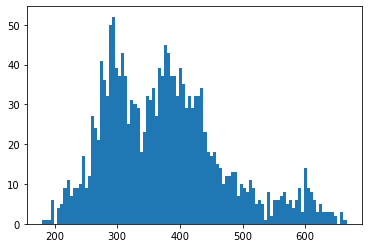

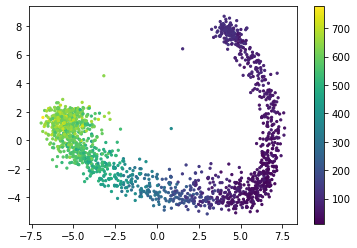

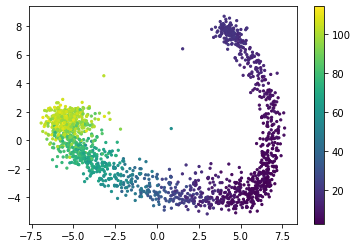

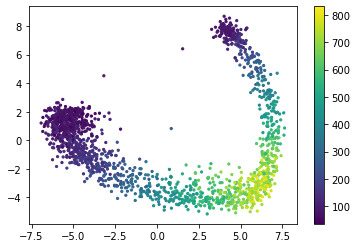

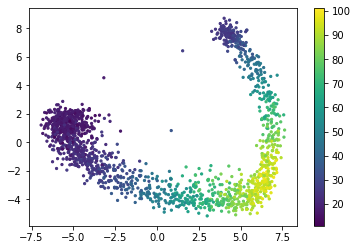

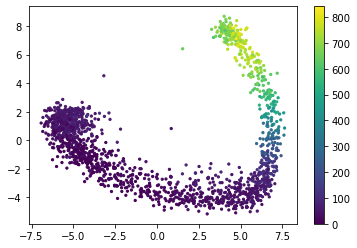

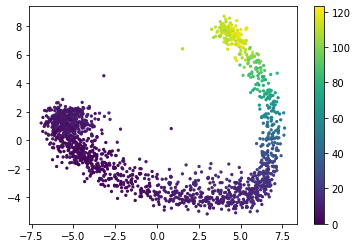

In [18]:
plt.hist(inter_counts,bins=100)
plt.show()
for p_ind in [0,1,2]:
    adata.obs['sub_intra']=sub_intra_counts[:,p_ind]
    # scv.pl.scatter(adata, basis='pca',color='part_num')
    plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=sub_intra_counts[:,p_ind],cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()
    
    adata.obs['sub_ON']=sub_ON_gene[:,p_ind]
    # scv.pl.scatter(adata, basis='pca',color='part_num')
    plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=sub_ON_gene[:,p_ind],cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()

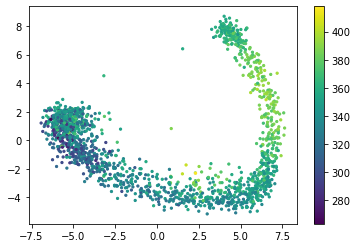

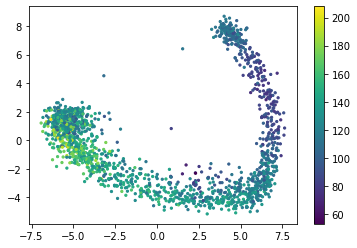

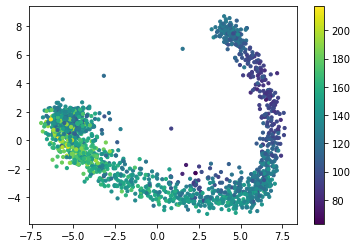

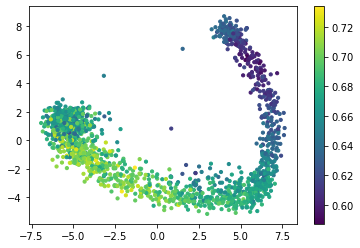

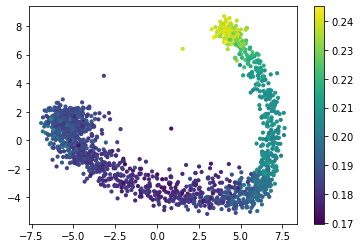

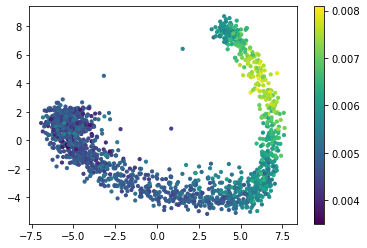

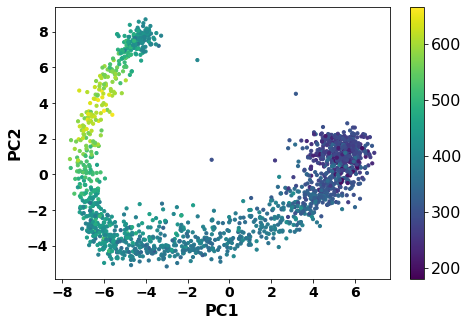

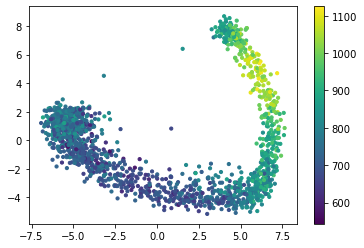

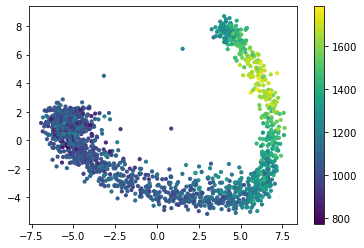

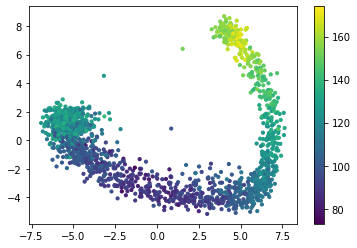

In [19]:
adata.obs['lgc']=lgc
adata.obs['cc_num']=cc_num
adata.obs['part_num']=part_num
adata.obs['mean_edge_weight']=mean_edge_weight
adata.obs['edge_density']=edge_density
adata.obs['inter_com']=inter_counts
adata.obs['intra_com']=intra_counts
adata.obs['ON_gene']=ON_gene
# scv.pl.scatter(adata, basis='pca',color='part_num')
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=lgc,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=cc_num,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=part_num,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()


plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=mean_edge_weight,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=edge_density,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=inter_counts,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_inter_com_counts_'+str(res_v)+'.png',dpi=300)
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=intra_counts,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=np.array(intra_counts)+np.array(inter_counts),cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=ON_gene,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

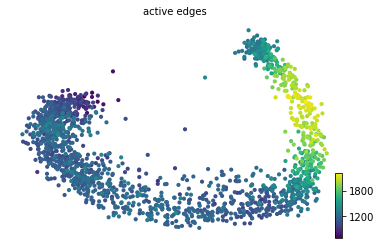

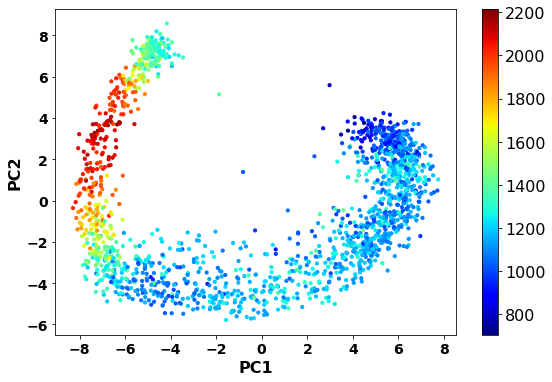

In [19]:
def eff_edges(X1,X2,F):
    F_sign=(np.sign((X1>0).astype(np.int)*((F*X2).T))).T
    edge_num=np.where(F_sign)[0].shape[0]
    return edge_num

eff_edge_count=[]
for i in range(X0_bin.shape[0]):
    eff_edge_count.append(eff_edges(X0_bin[i,:],X0_bin[i,:],F))
adata.obs['active edges']=eff_edge_count
scv.pl.scatter(adata, basis='pca',color='active edges')


fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=eff_edge_count,cmap=plt.cm.viridis)


plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_active_edge.png',dpi=300)
plt.show()

In [20]:
np.corrcoef(np.array(eff_edge_count),np.array(inter_counts))

array([[1.        , 0.92543505],
       [0.92543505, 1.        ]])

In [21]:
np.corrcoef(np.array(ON_gene),np.array(inter_counts))

array([[1.        , 0.27924784],
       [0.27924784, 1.        ]])

In [22]:
#-----------resilence-----------------------

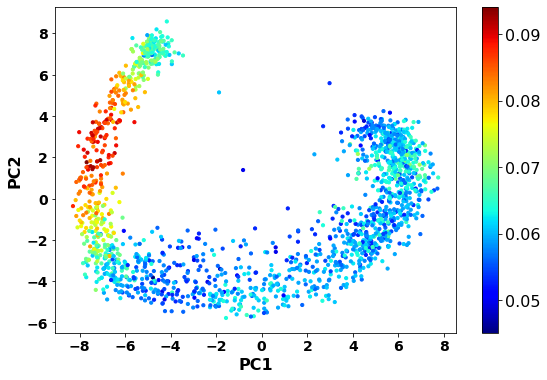

In [23]:
def degree_hetero(F):
    arr=np.array([np.count_nonzero(F[i,:])+np.count_nonzero(F[:,i]) for i in range(F.shape[0])])
    uni_k,counts=np.unique(arr,return_counts=True)
    pk=counts/np.sum(counts)
    deg_h=np.sum((1-pk)**2)/F.shape[0]
    return deg_h

deg_h=[]
for i in range(X0_bin.shape[0]):
    F_sign=(np.sign((X0_bin[i,:]>0).astype(np.int)*((F*X0_bin[i,:]).T))).T
    F_eff=np.multiply(F_sign,F)
    
    deg_h.append(degree_hetero(F_eff))
    
adata.obs['deg_h']=deg_h
# scv.pl.scatter(adata, basis='pca',color='part_num')
fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=deg_h,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_degree_hetero.png',dpi=300)
plt.show()

In [24]:
def Resilence(F,X):

    s_out=[np.count_nonzero(F[i,:]) for i in range(F.shape[0])]#/(np.count_nonzero(F[i,:])+np.count_nonzero(F[:,i])+1e-6)
    s_in=[np.count_nonzero(F[:,i]) for i in range(F.shape[1])]
    
#     _,out_counts=np.unique(np.array(s_out),return_counts=True)

#     sigma_P_out=np.std(out_counts/np.sum(out_counts))
    
#     _,in_counts=np.unique(np.array(s_in),return_counts=True)

#     sigma_P_in=np.std(in_counts/np.sum(in_counts))
    
    
    sigma_P_in=np.std(np.array(s_in))
    
    sigma_P_out=np.std(np.array(s_out))
    
#     print(sigma_P_in,sigma_P_out)
    
    mean_in=np.mean(np.array(s_in))
    mean_out=np.mean(np.array(s_out))
#     print(mean_in,mean_out)
    mean_degree=np.mean(np.array([np.count_nonzero(F[i,:])+np.count_nonzero(F[:,i]) for i in range(F.shape[0])]))
#     print(mean_degree)
    S=(np.mean(np.array([np.count_nonzero(F[i,:])*np.count_nonzero(F[:,i]) for i in range(F.shape[0])]))-mean_in*mean_out)/sigma_P_in/sigma_P_out
    
    H=sigma_P_in*sigma_P_out/mean_degree
    return mean_degree,H,S

In [25]:
hetero=[]
md=[]
symm=[]
for i in range(X0_bin.shape[0]):
    F_sign=(np.sign((X0_bin[i,:]>0).astype(np.int)*((F*X0_bin[i,:]).T))).T
    F_eff=np.multiply(F_sign,F)
    
    mean_d,h,s=Resilence(F_sign,X0_bin[i,:])
#     print(h,mean_d)
    hetero.append(h)
    md.append(mean_d)#/np.where(X0_bin[i,:]>0)[0].shape[0]
    symm.append(s)
hetero=np.array(hetero)

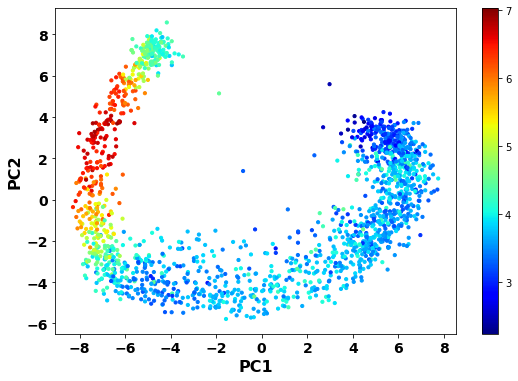

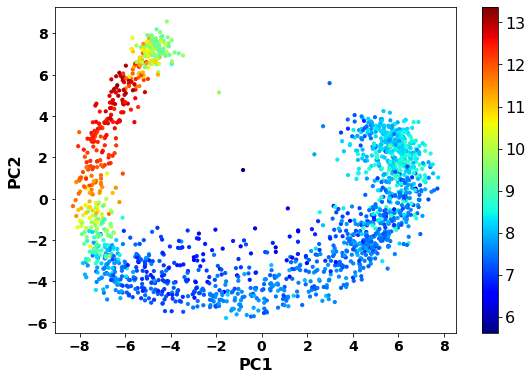

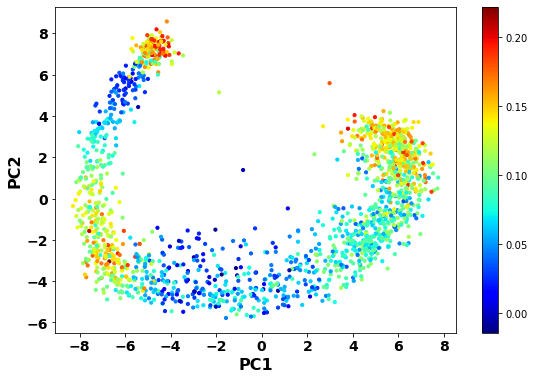

In [26]:
adata.obs['Heterogeneity']=hetero
adata.obs['md']=md
adata.obs['symm']=symm
# scv.pl.scatter(adata, basis='pca',color='part_num')
fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=md,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.colorbar()
# plt.savefig(result_path+'emt_edge_density.png',dpi=300)
plt.show()

fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=hetero,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_hetero.png',dpi=300)
plt.show()

fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=symm,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.colorbar()
# plt.savefig(result_path+'emt_symmetry.png',dpi=300)
plt.show()